In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector 
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import ZZFeatureMap

# Data encoding: from classical data to quantum data 
In this notebook we will take a look at various encoding, embedding or loading techniques which consists in methods that enable us to map classical data to its quantum counterpart to be used on a quantum computer. A crucial aspect in classical machine learning is the data representation: it is important to have a suitable numerical representation so that classical machine learning algorithm can process the dataset we want to study.
The same goes quantum machine learning: we want to map the classical input data into a quantum system efficiently so that it can be processed by a quantum algorithm rather than a classical one.\\
There are different methods that accomplish this task, we will look at three of them.
Let us start from a classical data set $\mathcal{D}$ which contains $M$ samples with $N$ features 
\begin{equation}
\mathcal{D} = \{x^1, x^2, \dots x^m, \dots x^M\}
\end{equation}
that is to say that $x^m \in \mathbb{R}^N(\forall m = 1,2,\dots, M)$ is an $N$ dimensional vector, usually with real entries.

# Basis encoding
This method associates a $N$ bit string to a $N$ dimensional computational basis state. In general we take the binary representation $x = (b_1, b_2, \dots, b_N)$ with $\{b_i\}_{i=1}^N \in \{0,1\}$ and construct the quantum state $\ket{x} = \ket{b_1b_2\dots b_N}$. In order to use this encoding, each element contained in $\mathcal{D}$ must be a $N$ bit string of the form $x^m = (b_1, b_2, \dots, b_N)$ which can be immediatly associated with the state $\ket{x^m} = \ket{b_1b_2\dots b_N}$. In this way the classical data set can be encoded using a superposition of all the $N$ basis states 
\begin{equation*}
\ket{\mathcal{D}} = \frac{1}{\sqrt{M}}\sum_{m = 1}^{M}\ket{x^m} 
\end{equation*}
Suppose the data set we have is 
$$
\mathcal{D}  =\{x^1 = 101,  x^2 = 111\} 
$$
which leads to the encoded state 
$$
\ket{\mathcal{D}} = \frac{1}{\sqrt{2}}\left(\ket{101}+\ket{111}\right)$$


In [2]:
zero = Statevector.from_label("0")                  # import basis state vectors 
one = Statevector.from_label("1")

state1 = one.tensor(zero).tensor(one)
state2 = one.tensor(one).tensor(one)
encoded_state = (state1 +state2)/sqrt(2)            # encoded state 

display(encoded_state.draw("latex"))                # check that the encoded state is correct


<IPython.core.display.Latex object>

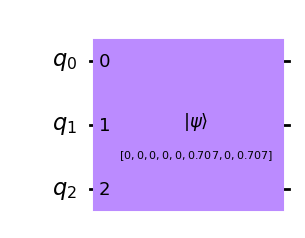

In [3]:
# create the quantum circuit that initializes this state 
qc = QuantumCircuit(3)                                      # N = 3 qubits since we have N = 3 bit string 
qc.initialize(encoded_state, [0,1,2])
qc.draw(output = "mpl", style = "clifford")

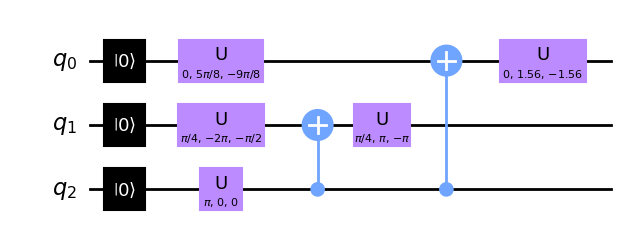

In [4]:
# decompose the circuit 
qc.decompose().decompose().decompose().decompose().decompose().draw(output = "mpl", style = "clifford")


# Amplitude encoding 
The next method we will look at is amplitude encoding which, as the name suggests, consists in encoding classical data into the amplitudes of a quantum state. More specifically having a normalised classical $N$ dimensional data point $x$, data in contained in the amplitudes of the state:
$$\ket{\psi_x} = \sum_{j = 0 }^{N}x_j \ket{j}$$
where $\{\ket{j}\}_{j = 1}^{N}$ are standad basis vector in $N = 2^n$ dimension and $x_i$ is the $i$-th element of the vector $x$. 
To encode the classical data set $\mathcal{D}$ into the quantum state we first need to concatenate all the vectors $x^m (m=1,2, \dots,M)$ into a normalised vector $y$ of dimension $N \times M$:
$$
y = A (x_1^{(1)}, x^{(1)}_2,\dots x^{(1)}_N,\dots x_1^{(M)}, x^{(M)}_2,\dots x^{(M)}_N)
$$
where $A$ is nome normalisation constraint such that $||y|| =1$. $y$ is also known as the amplitude vector and it is used to encode classical data in the following way
$$
\ket{\mathcal{D}} = \sum_{j=1}^{N}y_j\ket{j}
$$
where $y_j$ is the $j$-th element of the amplitude vector.
Supoose the classical data set is 
$$
\mathcal{D} = \{(1,0), (-2,3)\}
$$
then, the amplitude vector is just
$$ y = \frac{1}{\sqrt{14}}(1,0,-2,3)$$
The corrisponding encoded state is 
$$ 
\ket{D} = \frac{1}{\sqrt{14}}(\ket{00}-2\ket{10}+\ket{11})
$$

In [5]:
# create the encoded state 
zz = zero.tensor(zero)
oz = one.tensor(zero)
oo = one.tensor(one)
A = 1/sqrt(14)
encoded_state = (zz-2*oz+3*oo)*A
display(encoded_state.draw("latex"))
print(encoded_state.is_valid())

<IPython.core.display.Latex object>

True


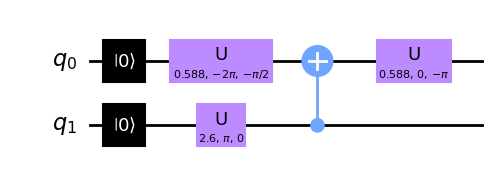

In [6]:
qca = QuantumCircuit(2)
qca.initialize(encoded_state, [0,1])
qca.decompose().decompose().decompose().decompose().decompose().draw(output = "mpl", style = "clifford")

# Angle encoding
Another method we can look at is the angle encoding method where $N$ features are encoded into rotation angles of $n$ qubits, where $n \leq N$. Given the data $x = (x_1, \dots, x_N) \in \mathcal{D}$ can be encoded as:
$$
\ket{x} = \bigotimes_{j=1}^{N}\cos(x_j)\ket{0}+\sin(x_j)\ket{1}
$$

Differently from the previous method, data is encoded one at the time instead as the whole dataset. This method, howevere, requires $N$ or less qubits, which makes it easier to implement on current quantum hardwares. One generalisation of this method is called the dense angle encoding, which enables to encode $2$ features per qubit, using a relative phase. The data point $x = (x_1,x_2,\dots, x_N)$ becomes
$$\ket{x} = \bigotimes_{j=1}^{N/2}\cos(x_{2j-1})\ket{0}+e^{ix_{2j}}\sin(x_{2j-1})\ket{1}$$

# Arbitrar encoding 
This methods encodes $N$ features as rotation on $N$ parametrized gates acting on $n$ qubits, where $n\leq N$. Just like angle encoding, data is encoded one at a time.
We follow with some examples.

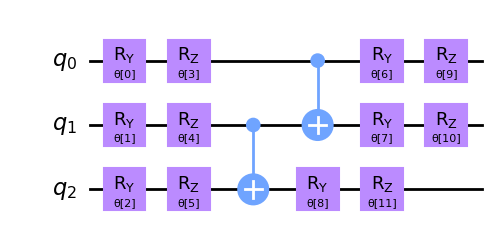

In [7]:
# EfficientSU(2)

SU2_circuit = EfficientSU2(num_qubits = 3, reps = 1)
SU2_circuit.decompose().draw(output = "mpl", style = "clifford")

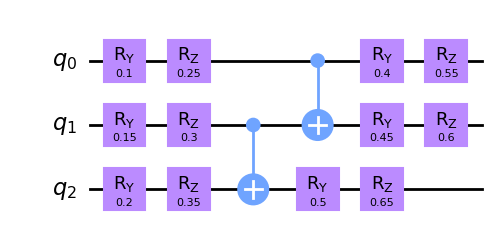

In [8]:
# here we encode the following data point with 12 features 
x = [0.1,0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65 ]
encode = SU2_circuit.assign_parameters(x)
encode.decompose().draw(output = "mpl", style = "clifford")

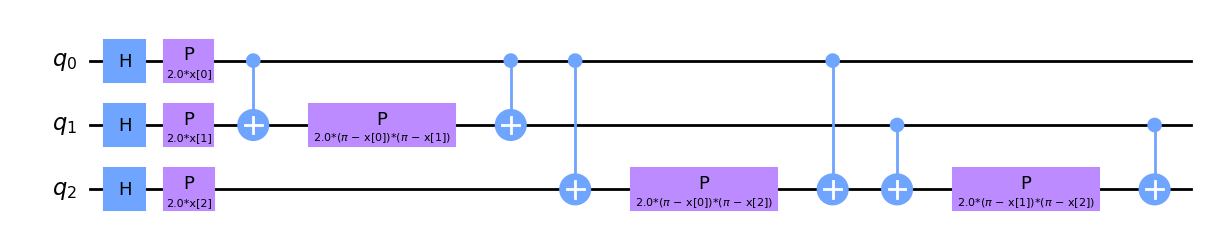

In [9]:
# we can also use the ZZfeatureMap which encode 3 features despite having 6 parameters 
circuit_zz = ZZFeatureMap(3, reps =1 )
circuit_zz.decompose().draw(output = "mpl", style = "clifford")

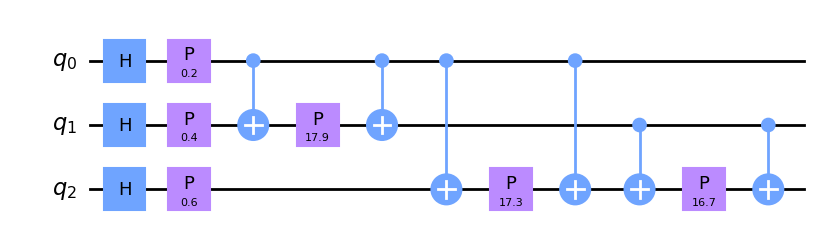

In [10]:
x = [0.1, 0.2, 0.3]                                     # data point to encode 
encode_zz = circuit_zz.assign_parameters(x)
encode_zz.decompose().draw(output = "mpl", style = "clifford")
